<a href="https://colab.research.google.com/github/isaacbilsel/GNN-Proteins/blob/isaac/Copy_of_TRIALPYT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install all PyTorch Geometric dependencies (CPU version)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
!pip install -q torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00


In [ ]:
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

# Load train, val, and test sets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

# Wrap in data loaders for batch training
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of nodes in first graph: {train_dataset[0].num_nodes}")
print(f"Feature shape: {train_dataset[0].x.shape}")
print(f"Labels shape: {train_dataset[0].y.shape}")


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Extracting data/PPI/ppi.zip
Processing...
/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

 

Number of training graphs: 20
Number of nodes in first graph: 1767
Feature shape: torch.Size([1767, 50])
Labels shape: torch.Size([1767, 121])


Done!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from sklearn.metrics import f1_score

# Load datasets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.conv2 = SAGEConv(hidden_feats, out_feats)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

# Init model, optimizer, loss
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.BCELoss()

# Evaluation helper
def evaluate(loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

# Training function with validation
def train_model(model, train_loader, val_loader, epochs=100):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation F1
        val_f1 = evaluate(val_loader)
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

# Train
train_model(model, train_loader, val_loader)

# Final test evaluation
test_f1 = evaluate(test_loader)
print(f"🎯 Final Test Micro-F1: {test_f1:.4f}")


Epoch 1/100, Loss: 0.5783, Val F1: 0.4126
Epoch 2/100, Loss: 0.5416, Val F1: 0.4385
Epoch 3/100, Loss: 0.5305, Val F1: 0.4549
Epoch 4/100, Loss: 0.5225, Val F1: 0.4898
Epoch 5/100, Loss: 0.5181, Val F1: 0.5055
Epoch 6/100, Loss: 0.5144, Val F1: 0.4831
Epoch 7/100, Loss: 0.5125, Val F1: 0.4545
Epoch 8/100, Loss: 0.5123, Val F1: 0.4290
Epoch 9/100, Loss: 0.5098, Val F1: 0.4574
Epoch 10/100, Loss: 0.5108, Val F1: 0.4914
Epoch 11/100, Loss: 0.5082, Val F1: 0.4755
Epoch 12/100, Loss: 0.5078, Val F1: 0.4831
Epoch 13/100, Loss: 0.5070, Val F1: 0.4951
Epoch 14/100, Loss: 0.5080, Val F1: 0.4567
Epoch 15/100, Loss: 0.5073, Val F1: 0.4500
Epoch 16/100, Loss: 0.5075, Val F1: 0.4964
Epoch 17/100, Loss: 0.5079, Val F1: 0.4426
Epoch 18/100, Loss: 0.5078, Val F1: 0.4968
Epoch 19/100, Loss: 0.5057, Val F1: 0.4751
Epoch 20/100, Loss: 0.5058, Val F1: 0.4798


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load datasets
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# Model definition
class DeepGraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(DeepGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, hidden_feats)
        self.bn1 = nn.BatchNorm1d(hidden_feats)

        self.conv2 = SAGEConv(hidden_feats, hidden_feats)
        self.bn2 = nn.BatchNorm1d(hidden_feats)

        self.conv3 = SAGEConv(hidden_feats, hidden_feats)
        self.bn3 = nn.BatchNorm1d(hidden_feats)

        self.conv4 = SAGEConv(hidden_feats, out_feats)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        return torch.sigmoid(x)

# Init
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepGraphSAGE(in_feats, hidden_feats, out_feats).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.BCELoss()

# Training function
def train(model, loader, epochs=100):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_f1 = 0

        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()

            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_loss += loss.item()
            total_f1 += f1

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(loader):.4f}, F1-score: {total_f1/len(loader):.4f}")

# Evaluation
def evaluate(model, loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

# Train
train(model, train_loader, epochs=100)

# Validate and Test
val_f1 = evaluate(model, val_loader)
test_f1 = evaluate(model, test_loader)
print(f"\n✅ Validation F1: {val_f1:.4f}")
print(f"✅ Test F1: {test_f1:.4f}")


Epoch 10/100, Loss: 0.4394, F1-score: 0.6169
Epoch 20/100, Loss: 0.3977, F1-score: 0.6663
Epoch 30/100, Loss: 0.3889, F1-score: 0.6812
Epoch 40/100, Loss: 0.3904, F1-score: 0.6801
Epoch 50/100, Loss: 0.3771, F1-score: 0.6935
Epoch 60/100, Loss: 0.3778, F1-score: 0.6930
Epoch 70/100, Loss: 0.3725, F1-score: 0.6970
Epoch 80/100, Loss: 0.3729, F1-score: 0.6982
Epoch 90/100, Loss: 0.3720, F1-score: 0.7004
Epoch 100/100, Loss: 0.3773, F1-score: 0.6933

✅ Validation F1: 0.7204
✅ Test F1: 0.7342


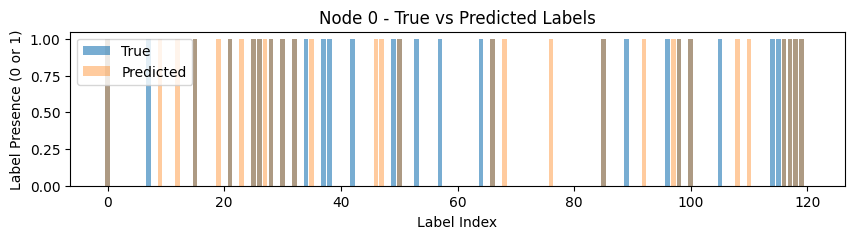

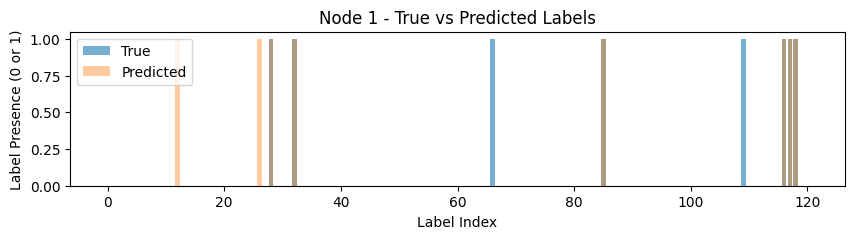

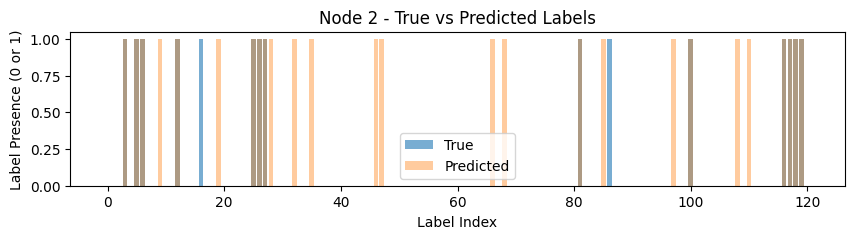

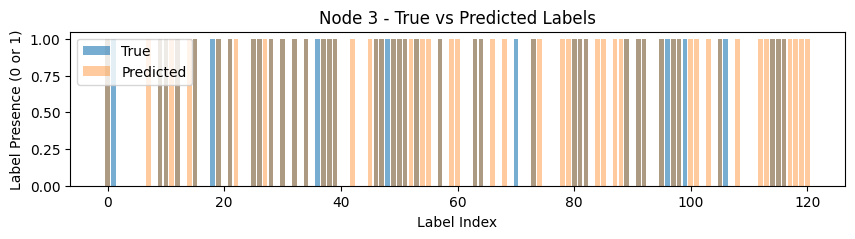

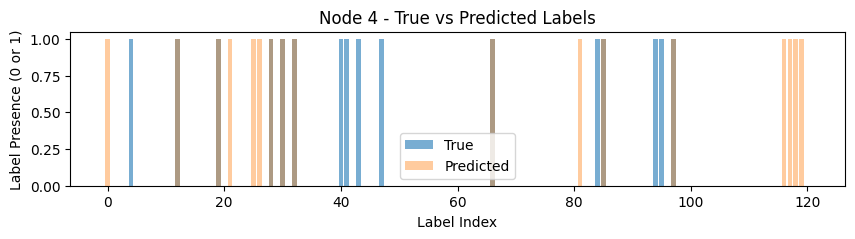

In [ ]:
# Visualize predictions for the first graph in test set
model.eval()
sample = test_dataset[0].to(device)

with torch.no_grad():
    pred = model(sample.x, sample.edge_index)
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted labels for first 5 nodes
num_nodes_to_plot = 5
for i in range(num_nodes_to_plot):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Node {i} - True vs Predicted Labels")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence (0 or 1)")
    plt.legend()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load dataset
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# Define GAT model
class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, heads=4):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_feats, hidden_feats, heads=heads)
        self.gat2 = GATConv(hidden_feats * heads, hidden_feats, heads=heads)
        self.gat3 = GATConv(hidden_feats * heads, out_feats, heads=1)
        self.activation = nn.ELU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index)
        return torch.sigmoid(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 256

model = GAT(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.BCELoss()

# Evaluation function
def evaluate(model, loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

# Training
def train(model, train_loader, val_loader, epochs=100):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_f1 = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()

            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_loss += loss.item()
            total_f1 += f1

        if epoch % 10 == 0:
            val_f1 = evaluate(model, val_loader)
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
                  f"Train F1: {total_f1/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

# Train the GAT model
train(model, train_loader, val_loader, epochs=100)

# Final test performance
test_f1 = evaluate(model, test_loader)
print(f"🎯 Final Test Micro-F1: {test_f1:.4f}")


Epoch 10/100, Loss: 0.5245, Train F1: 0.4725, Val F1: 0.5115
Epoch 20/100, Loss: 0.5262, Train F1: 0.4693, Val F1: 0.4640
Epoch 30/100, Loss: 0.5121, Train F1: 0.4980, Val F1: 0.4945
Epoch 40/100, Loss: 0.5037, Train F1: 0.5146, Val F1: 0.5517
Epoch 50/100, Loss: 0.5032, Train F1: 0.5113, Val F1: 0.5373
Epoch 60/100, Loss: 0.5035, Train F1: 0.5142, Val F1: 0.5318
Epoch 70/100, Loss: 0.5061, Train F1: 0.5090, Val F1: 0.5344
Epoch 80/100, Loss: 0.5030, Train F1: 0.5184, Val F1: 0.5614
Epoch 90/100, Loss: 0.4985, Train F1: 0.5251, Val F1: 0.4997
Epoch 100/100, Loss: 0.4979, Train F1: 0.5212, Val F1: 0.5386
🎯 Final Test Micro-F1: 0.5439


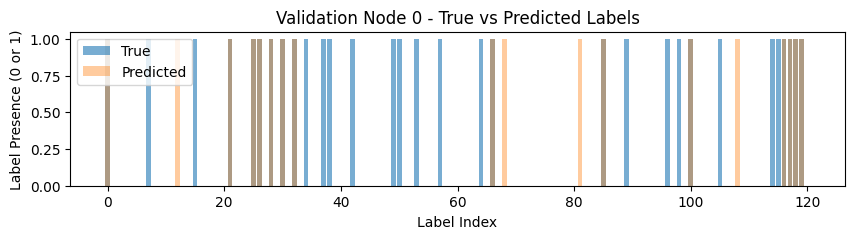

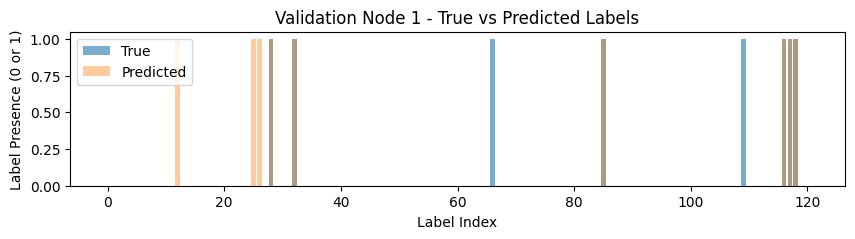

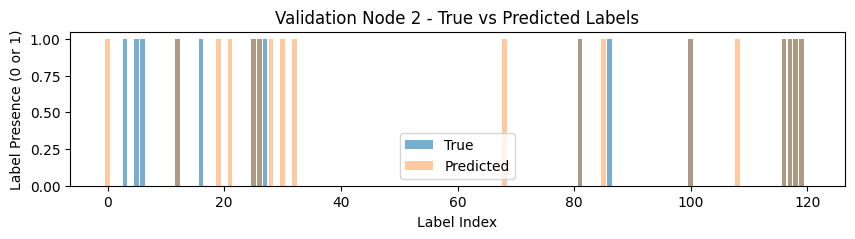

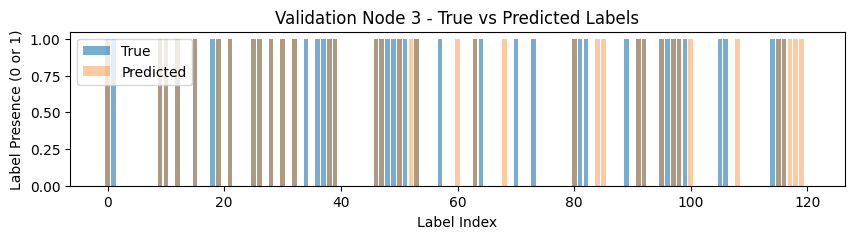

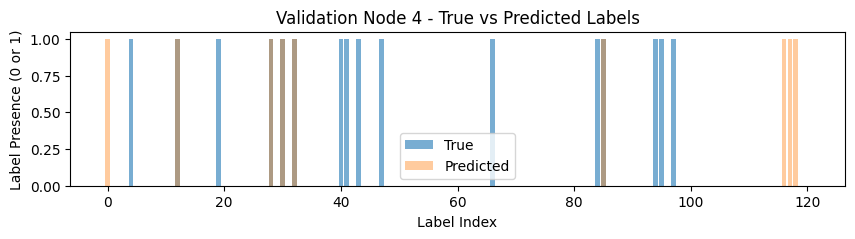

In [ ]:
# Switch model to eval mode
model.eval()

# Get first validation graph
sample = val_dataset[0].to(device)

# Predict
with torch.no_grad():
    pred = model(sample.x, sample.edge_index)
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted labels for first 5 nodes
num_nodes_to_plot = 5
for i in range(num_nodes_to_plot):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Validation Node {i} - True vs Predicted Labels")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence (0 or 1)")
    plt.legend()
    plt.show()


Epoch 10/100, Loss: 0.5745, Train F1: 0.4129, Val F1: 0.4267
Epoch 20/100, Loss: 0.5526, Train F1: 0.4556, Val F1: 0.4177
Epoch 30/100, Loss: 0.5506, Train F1: 0.4428, Val F1: 0.4389
Epoch 40/100, Loss: 0.5468, Train F1: 0.4479, Val F1: 0.4563
Epoch 50/100, Loss: 0.5462, Train F1: 0.4472, Val F1: 0.4413
Epoch 60/100, Loss: 0.5464, Train F1: 0.4579, Val F1: 0.4397
Epoch 70/100, Loss: 0.5460, Train F1: 0.4526, Val F1: 0.4573
Epoch 80/100, Loss: 0.5459, Train F1: 0.4534, Val F1: 0.4422
Epoch 90/100, Loss: 0.5468, Train F1: 0.4517, Val F1: 0.4288
Epoch 100/100, Loss: 0.5472, Train F1: 0.4513, Val F1: 0.4032

✅ Final Test Micro-F1 (GCN): 0.4113


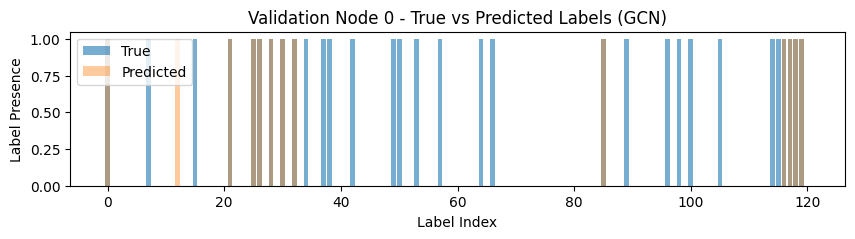

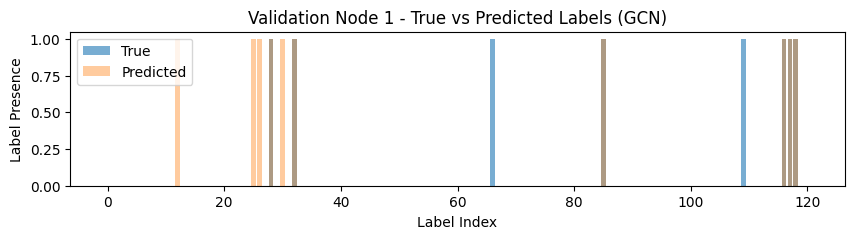

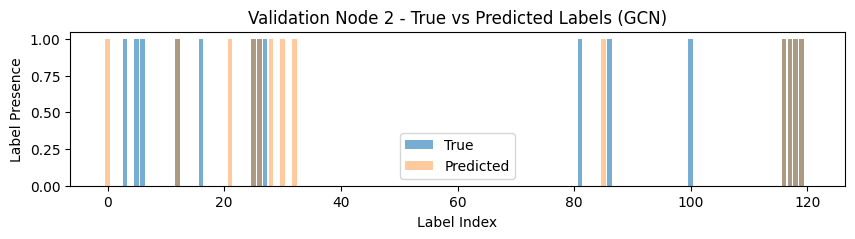

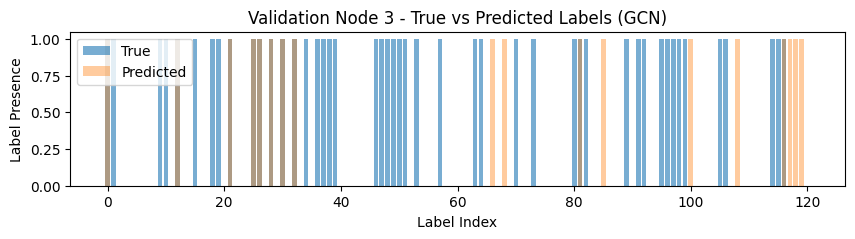

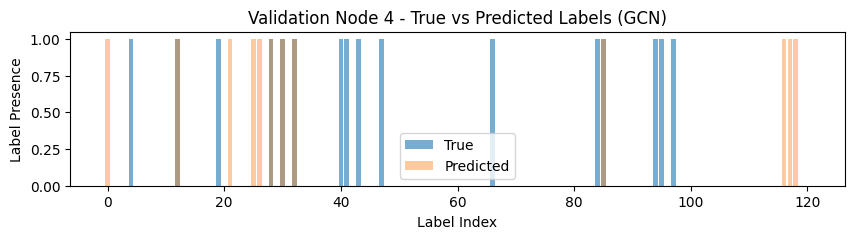

In [ ]:
# ---- INSTALLS (if running in Google Colab) ----
# Uncomment if not installed
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
# !pip install -q torch-geometric

# ---- IMPORTS ----
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# ---- LOAD DATA ----
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- MODEL DEFINITION ----
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, hidden_feats)
        self.conv3 = GCNConv(hidden_feats, out_feats)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        return torch.sigmoid(x)

# ---- INIT MODEL, OPTIMIZER ----
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 256

model = GCN(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = nn.BCELoss()

# ---- EVALUATION FUNCTION ----
def evaluate(model, loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

# ---- TRAINING FUNCTION ----
def train(model, train_loader, val_loader, epochs=100):
    train_f1_history = []
    val_f1_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_train_f1 = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()

            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_loss += loss.item()
            total_train_f1 += f1

        train_f1 = total_train_f1 / len(train_loader)
        val_f1 = evaluate(model, val_loader)

        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
                  f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    return train_f1_history, val_f1_history

# ---- RUN TRAINING ----
train_f1s, val_f1s = train(model, train_loader, val_loader, epochs=100)

# ---- FINAL TEST EVALUATION ----
test_f1 = evaluate(model, test_loader)
print(f"\n✅ Final Test Micro-F1 (GCN): {test_f1:.4f}")

# ---- VISUALIZE PREDICTIONS ON VALIDATION SET ----
model.eval()
sample = val_dataset[0].to(device)

with torch.no_grad():
    pred = model(sample.x, sample.edge_index)
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted labels for first 5 nodes
for i in range(5):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Validation Node {i} - True vs Predicted Labels (GCN)")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence")
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Extracting data/PPI/ppi.zip
Processing...
/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

 

Epoch 10/100, Loss: 0.5201, Train F1: 0.5488, Val F1: 0.4981
Epoch 20/100, Loss: 0.5120, Train F1: 0.5488, Val F1: 0.5446
Epoch 30/100, Loss: 0.5048, Train F1: 0.5484, Val F1: 0.5301
Epoch 40/100, Loss: 0.4989, Train F1: 0.5513, Val F1: 0.5099
Epoch 50/100, Loss: 0.4981, Train F1: 0.5517, Val F1: 0.5034
Epoch 60/100, Loss: 0.4947, Train F1: 0.5524, Val F1: 0.5001
Epoch 70/100, Loss: 0.4935, Train F1: 0.5517, Val F1: 0.5137
Epoch 80/100, Loss: 0.4905, Train F1: 0.5536, Val F1: 0.5319
Epoch 90/100, Loss: 0.4900, Train F1: 0.5515, Val F1: 0.5536
Epoch 100/100, Loss: 0.4891, Train F1: 0.5556, Val F1: 0.5330

✅ Final Test Micro-F1 (Better GCN): 0.5500


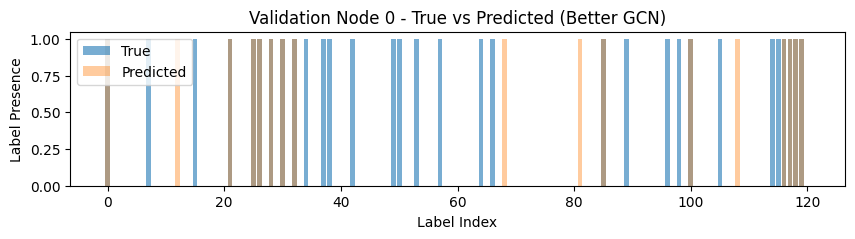

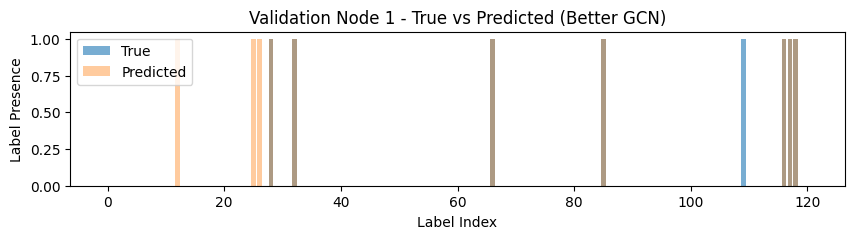

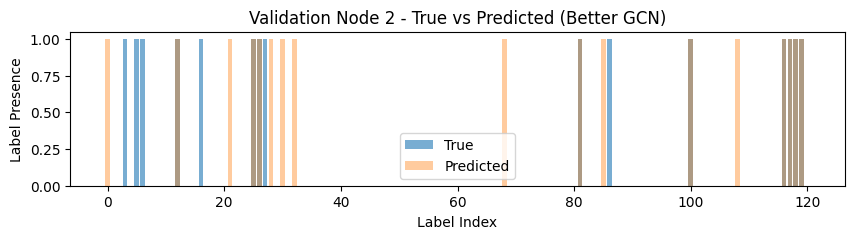

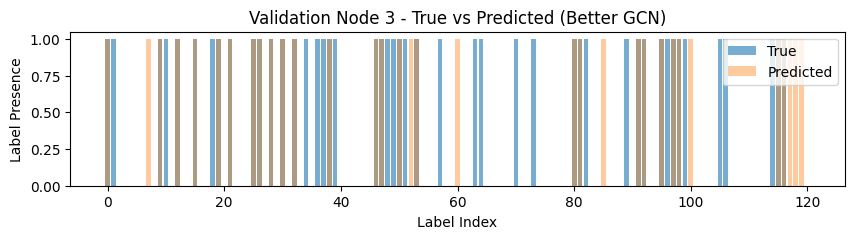

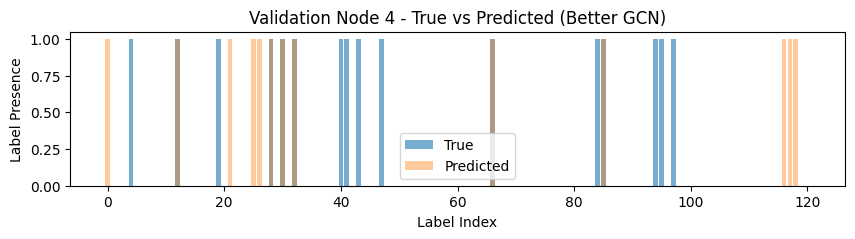

In [ ]:
# ---- INSTALLS (if running in Google Colab) ----
# Uncomment if needed
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cpu.html
# !pip install -q torch-geometric

# ---- IMPORTS ----
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# ---- LOAD DATA ----
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- OPTIMIZED MODEL ----
class BetterGCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(BetterGCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.bn1 = nn.BatchNorm1d(hidden_feats)

        self.conv2 = GCNConv(hidden_feats, hidden_feats)
        self.bn2 = nn.BatchNorm1d(hidden_feats)

        self.conv3 = GCNConv(hidden_feats, out_feats)

        self.act = nn.ELU()  # Better for deep GNNs
        self.dropout = nn.Dropout(0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        return torch.sigmoid(x)

# ---- INIT MODEL, OPTIMIZER, SCHEDULER ----
in_feats = train_dataset.num_node_features
out_feats = train_dataset.num_classes
hidden_feats = 512  # Increased hidden size

model = BetterGCN(in_feats, hidden_feats, out_feats).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)
loss_fn = nn.BCELoss()

# ---- EVALUATION ----
def evaluate(model, loader):
    model.eval()
    total_f1 = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_f1 += f1
    return total_f1 / len(loader)

# ---- TRAINING ----
def train(model, train_loader, val_loader, epochs=100):
    train_f1_history = []
    val_f1_history = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_train_f1 = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer.step()

            preds = (out > 0.5).float()
            f1 = f1_score(batch.y.cpu().numpy(), preds.cpu().numpy(), average='micro')
            total_loss += loss.item()
            total_train_f1 += f1

        scheduler.step()

        train_f1 = total_train_f1 / len(train_loader)
        val_f1 = evaluate(model, val_loader)
        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
                  f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

    return train_f1_history, val_f1_history

# ---- RUN TRAINING ----
train_f1s, val_f1s = train(model, train_loader, val_loader, epochs=100)

# ---- FINAL TEST ----
test_f1 = evaluate(model, test_loader)
print(f"\n✅ Final Test Micro-F1 (Better GCN): {test_f1:.4f}")

# ---- PREDICTION VISUALIZATION ----
model.eval()
sample = val_dataset[0].to(device)
with torch.no_grad():
    pred = model(sample.x, sample.edge_index)
    pred_bin = (pred > 0.5).float().cpu()

# Plot true vs predicted for 5 nodes
for i in range(5):
    plt.figure(figsize=(10, 2))
    plt.bar(range(out_feats), sample.y[i].cpu(), alpha=0.6, label='True')
    plt.bar(range(out_feats), pred_bin[i], alpha=0.4, label='Predicted')
    plt.title(f"Validation Node {i} - True vs Predicted (Better GCN)")
    plt.xlabel("Label Index")
    plt.ylabel("Label Presence")
    plt.legend()
    plt.show()

